In [34]:
from dotenv import load_dotenv
import os

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

In [2]:
from unstructured.partition.pdf import partition_pdf

output_path = "./content/"
file_path = output_path + 'Arthur Maciel - PG1 - Projeto de Melhoria do Sistema de Exaustão para o Restaurante Universitário da UnB.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,
    languages=["por+eng"],

    # extract_images_in_pdf=True,          # deprecated
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [3]:
# Mostra quantos elementos foram extraídos
print(f"Total de elementos extraídos: {len(chunks)}\n")

# Mostra os primeiros elementos
for i, chunk in enumerate(chunks[:5]):
    print(f"\n--- Chunk {i+1} ---")
    print(f"Tipo: {type(chunk)}")
    print(f"Texto:\n{chunk.text}")

Total de elementos extraídos: 29


--- Chunk 1 ---
Tipo: <class 'unstructured.documents.elements.CompositeElement'>
Texto:
PROJETO DE GRADUAÇÃO 1

Projeto de Melhoria do Sistema de Exaustão para o Restaurante Universitário da UnB

Arthur da Silva Maciel

Brasília, Julho de 2025

UNIVERSIDADE DE BRASÍLIA

FACULDADE DE TECNOLOGIA

UNIVERSIDADE DE BRASÍLIA

Faculdade de Tecnologia

Departamento de Engenharia Mecânica

PROJETO DE GRADUAÇÃO 1

Projeto de Melhoria do Sistema de Exaustão para o Restaurante Universitário da UnB

Arthur da Silva Maciel

Projeto de Graduação 1 submetido ao Departamento de Engenharia

Mecânica como requisito parcial para obtenção

do grau de Engenheiro em Engenharia Mecânica

Banca Examinadora

Prof. Dr. João Manoel Dias Pimenta, ENM/UnB Orientador

Prof. Dr. Mario Benjamin Baptista de Siqueira,

ENM/UnB Examinador interno

Prof. Dr. Edgar Amaral Silveira, ENM/UnB

Examinador interno

FICHA CATALOGRÁFICA

MACIEL, ARTHUR DA SILVA

Projeto de Melhoria do Sistema de

In [4]:
with open("conteudo_extraido.txt", "w", encoding="utf-8") as f:
    for chunk in chunks:
        f.write(chunk.text + "\n\n")

In [5]:
for chunk in chunks:
    print(type(chunk), "-", chunk.text[:80])

<class 'unstructured.documents.elements.CompositeElement'> - PROJETO DE GRADUAÇÃO 1

Projeto de Melhoria do Sistema de Exaustão para o Restau
<class 'unstructured.documents.elements.CompositeElement'> - Agradecimentos

Gostaria de, primeiramente, dedicar este trabalho a Universidade
<class 'unstructured.documents.elements.CompositeElement'> - SUMÁRIO

1 INTRODUÇÃO ..........................................................
<class 'unstructured.documents.elements.CompositeElement'> - LISTA DE FIGURAS

2.1 Ventilação Diluidora Natural..............................
<class 'unstructured.documents.elements.CompositeElement'> - LISTA DE TABELAS

4.1 Perguntas do Formulário...................................
<class 'unstructured.documents.elements.CompositeElement'> - 2

no RU, sendo necessário dar condições apropriadas para que assim consigam ter
<class 'unstructured.documents.elements.CompositeElement'> - 1.2.2 Projetos Emblemáticos

Estudar e compreender projetos já realizados em Res
<class

In [7]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [23]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[10].metadata.orig_elements

In [24]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[10].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': 'f49b5c44-07cc-41a3-b9f5-fbf5d5f662fb',
 'text': '',
 'metadata': {'coordinates': {'points': ((np.float64(511.81111111111113),
     np.float64(323.36722222222215)),
    (np.float64(511.81111111111113), np.float64(1177.5138888888887)),
    (np.float64(1141.7442777777778), np.float64(1177.5138888888887)),
    (np.float64(1141.7442777777778), np.float64(323.36722222222215))),
   'system': 'PixelSpace',
   'layout_width': 1654,
   'layout_height': 2339},
  'last_modified': '2025-08-07T12:56:58',
  'filetype': 'PPM',
  'languages': ['por', 'eng'],
  'page_number': 21,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCANXAnYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NT

In [25]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [27]:
print(tables)

[]


In [20]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

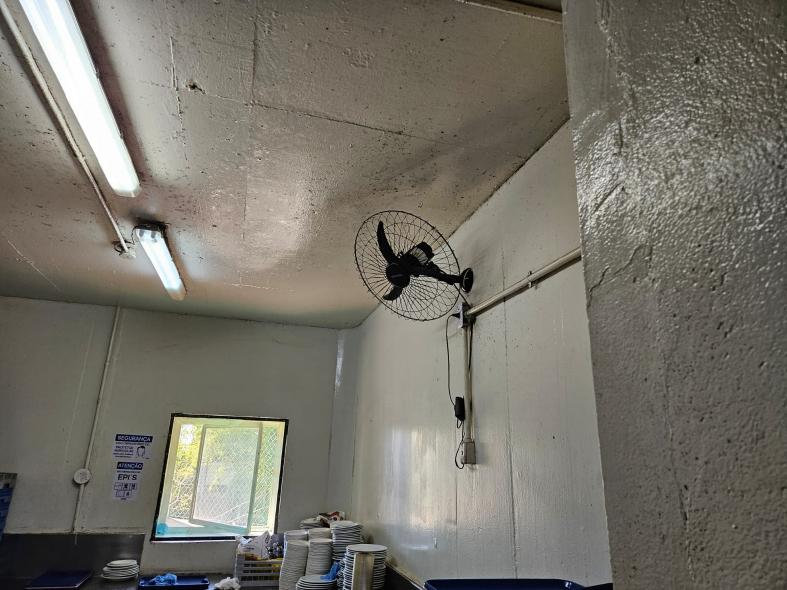

In [56]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[25])

In [32]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [118]:
# Prompt
prompt_text = """
You are an assistant. If the input is a question, answer it clearly and concisely.
If the input is a piece of text or table, summarize it.

Input:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(api_key=groq_api_key,temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [60]:
import time
from langchain_core.runnables import Runnable
from typing import List

def safe_batch_process(chain: Runnable, data: List[str], batch_size=1, wait_on_error=10):
    results = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        try:
            batch_results = chain.batch(batch, {"max_concurrency": 2})
            results.extend(batch_results)
        except Exception as e:
            print(f"⏱️ Rate limit atingido ou erro: {e}")
            print(f"🔁 Esperando {wait_on_error} segundos para tentar de novo...")
            time.sleep(wait_on_error)
            # tenta o mesmo batch de novo
            try:
                batch_results = chain.batch(batch, {"max_concurrency": 2})
                results.extend(batch_results)
            except Exception as e2:
                print(f"❌ Ainda deu erro: {e2} — pulando esse batch.")
    return results


In [100]:
text_summaries = safe_batch_process(summarize_chain, texts)

In [101]:
text_summaries

['This is a graduation project titled "Projeto de Melhoria do Sistema de Exaustão para o Restaurante Universitário da UnB" submitted by Arthur da Silva Maciel to the Department of Mechanical Engineering at the University of Brasília in 2025.',
 'Agradecimentos são feitos à Universidade de Brasília, família, professores e empresa pela contribuição para o desenvolvimento e formação como profissional.',
 'This document is a research study on ventilation and thermal comfort, divided into 5 chapters: introduction, ventilation review, thermal comfort review, case study, and preliminary results.',
 'The provided text is a list of 35 chapters (4.1-4.35, 5.1, I.1) related to a university restaurant (RU), covering various topics such as ventilation systems, thermal comfort, and user behavior, including frequency of use, age, gender, and physical discomfort.',
 'O presente trabalho objetiva idealizar o projeto de melhoria do sistema de exaustão do Restaurante Universitário da Universidade de Bras

In [45]:
table_summaries = safe_batch_process(summarize_chain, tables)

In [46]:
table_summaries

[]

In [73]:
from PIL import Image
from io import BytesIO
import base64
import pytesseract

def ocr_from_images_base64(images_b64):
    image_texts = []
    for b64 in images_b64:
        try:
            image_data = base64.b64decode(b64)
            image = Image.open(BytesIO(image_data))
            text = pytesseract.image_to_string(image, lang="por+eng")
            image_texts.append(text)
        except Exception as e:
            print(f"❌ Erro ao processar imagem: {e}")
    return image_texts

ocr_texts = ocr_from_images_base64(images)

In [86]:
# Prompt com variável {element}
prompt_text_image = """
The following is OCR-extracted text from an image found in a technical document.

Describe in detail what the image is likely showing, based on the text.
Be specific about diagrams, graphs, or bar plots if relevant.

OCR text:
{element}
"""

prompt_image = ChatPromptTemplate.from_template(prompt_text_image)

# Agora sim, o chain está coerente
summarize_chain = {"element": lambda x: x} | prompt_image | model | StrOutputParser()

In [87]:
image_summaries = safe_batch_process(summarize_chain, ocr_texts)

In [88]:
image_summaries

["I'm ready to help, but you haven't provided the OCR-extracted text yet. Please go ahead and paste the text, and I'll do my best to describe the image based on the content.",
 "I'm ready to help. However, you haven't provided the OCR-extracted text from the image. Please paste the text, and I'll do my best to describe what the image is likely showing.",
 "However, you haven't provided the OCR-extracted text yet. Please go ahead and share the text, and I'll do my best to describe the image based on the information provided.",
 'Based on the OCR-extracted text, it appears that the image is likely showing a comparison of different air intake systems in a ventilation or air distribution context. The text suggests that the image is a diagram or a series of diagrams illustrating different ways to improve air intake.\n\nThe text mentions a "tubo de distribuição vertical" (vertical distribution tube), which is likely a reference to a vertical duct or pipe used to distribute air. The text also

In [90]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.embeddings import HuggingFaceEmbeddings

embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embedding_function)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

C:\Users\Orçamento\AppData\Local\Temp\ipykernel_332\3101373717.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
c:\Users\Orçamento\Desktop\ENGENHORCA\.venvengenhorca\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Orçamento\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be di

In [92]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
#table_ids = [str(uuid.uuid4()) for _ in tables]
#summary_tables = [
    #Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)]
#retriever.vectorstore.add_documents(summary_tables)
#retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [103]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)
print(docs)

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJPAxMDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDLy2Mc/jTXTcOSanR1xwoprjeCQcf0rrMiqY9vGaRowR15qUw/7dMKhT96kMgaMAnjNAjHp705wpOCMD61G0mykApQdsVWkCdGAI9hTpJgBkkf41XDB3I5JPQ44oAc0cYG7PH1qIooyF6H3qwY+BkBvY0jRAtwMEUARgED8O

In [94]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAJPAxMDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDLy2Mc/jTXTcOSanR1xwoprjeCQcf0rrMiqY9vGaRowR15qUw/7dMKhT96kMgaMAnjNAjHp705wpOCMD61G0mykApQdsVWkCdGAI9hTpJgBkkf41XDB3I5JPQ44oAc0cYG7PH1qIooyF6H3qwY+BkBvY0jRAtwMEUARgED8O3a

In [126]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq
from base64 import b64decode
import os

# LLM - Groq com LLaMA 3
model = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY"),
    model="llama-3.1-8b-instant",
    temperature=0.2
)

# Separa textos e imagens, mas ignora imagens no processamento
def parse_docs(docs):
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)  # ← será ignorado, mas salvo se quiser usar depois
        except Exception:
            text.append(doc)
    return {"images": b64, "texts": text}

# Monta prompt apenas com texto extraído
def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text + "\n\n"

    prompt_template = f"""
Você é um assistente técnico. Responda com base apenas no seguinte contexto (extraído de documentos PDF e imagens convertidas para texto):

{context_text}

Pergunta: {user_question}
Resposta:
    """

    return prompt_template.strip()

# Chain simples
chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | model
    | StrOutputParser()
)

# Chain com fontes (retorna também o contexto usado)
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | model
        | StrOutputParser()
    )
)


In [132]:
response = chain.invoke(
    "Quem é o autor do Projeto de Melhoria do Sistema de Exaustão para o Restaurante Universitário da UnB?"
)

print(response)

Arthur da Silva Maciel.


In [129]:
response = chain_with_sources.invoke(
    "What is multihead?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: Multihead é uma tecnologia de processamento de vídeo que permite que uma placa-mãe ou uma GPU (Unidade de Processamento Gráfico) processe várias saídas de vídeo simultaneamente. Isso é útil em aplicações que requerem múltiplas saídas de vídeo, como em estúdios de TV, centros de dados e sistemas de visualização de dados.


Context:


TypeError: 'module' object is not callable